# Hopfield Neural Network Approach

## 1. Hopfield Neural Network Knapsack Solver Implementation

### 1.1 Import Packages

In [1]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt

### 1.2 Class of HNN Knapsack Solver

In [2]:
class HNNKnapsack:

    def __init__(self, alpha, rep, data_file, number_store = 579, solve_special_zone=True, solve_opt_priority=True):

        self.solve_special_zone = solve_special_zone
        self.solve_opt_priority = solve_opt_priority

        self.rep = rep
        self.alpha = alpha
        self.T_List = 10 * np.logspace(0, 2000, num=rep, base=0.99)

        self.data = pd.read_csv(data_file)
        self.data.insert(loc=6, column="KPI_C", value=self.data["KPI_1"]-self.data["KPI_2"]/1)

        self.SID = list(self.data["STORE_ID_DUMMY"])
        self.s_index = list(self.process_store_index(self.SID))
        self.n_store = len(self.s_index)-1
        self.number_store = number_store

        self.data = self.data[0:self.s_index[number_store]]
        self.PID = list(self.data["PRODUCT_ID_DUMMY"])
        self.SPC = np.array(self.data["SPACE_VALUE"])
        self.KPI1 = np.array(self.data["KPI_1"])
        self.KPI2 = np.array(self.data["KPI_2"])
        self.KPIC = np.array(self.data["KPI_C"])
        self.OPT = np.array(self.data["opt_priority"])
        self.SZT = np.nan_to_num(list(self.data["SPECIAL_ZONE_TAG"]))
        self.NSZT = 1 - self.SZT
        self.MAX_SPC = list(self.data["STORE_SPACE_TO_OPTIMISE"][self.s_index[0:number_store]])
        self.MAX_SPC_SZT = list(self.process_max_spc_szt(self.data["STORE_SPACE_TO_OPTIMISE_SPECIAL_ZONE"]))

        self.start = None
        self.end = None
        self.time = []

        self.solution = []
        self.result = []

    def process_store_index(self, SID):
        s_size = []
        for i in pd.unique(SID):
            s_size.append(SID.count(i))
        s_index = [0]
        s_index.extend(list(np.cumsum(s_size)))
        return s_index

    def process_max_spc_szt(self, SPC_SZT):
        MAX_SPC_SZT = []
        for i in range(self.n_store):
            a = list(np.unique(SPC_SZT[(self.s_index[i]):(self.s_index[i+1])].dropna()))
            if a != []:
                MAX_SPC_SZT.append(a[0])
            else:
                MAX_SPC_SZT.append(0)
        return MAX_SPC_SZT

    # Activation function
    def sigmoid(self, value):
        return (1/2) * (1 + math.tanh(value))

    # Penalty function for space constrains
    def pnf1(self, value):
        return max(0, 50 * self.alpha * value)

    # Penalty function for selection constrains
    def pnf2(self, value):
        return 50 * value ** 2

    # Penalty function for priority constrains
    def pnf3(self, value):
        return np.where(self.alpha * value < 0, 0, self.alpha * value)

    # Function to create a matrix that identify product
    def create_product_indentify_matrix(self, product_id):

        p_size = []
        for i in pd.unique(product_id):
            p_size.append(product_id.count(i))
        p_index = [0]
        p_index.extend(list(np.cumsum(p_size)))

        C = [[0] * len(product_id) for _ in range(len(p_size))]
        for i in range(len(p_size)):
            for j in range(p_index[i], p_index[i+1]):
                C[i][j] = 1

        return np.array(C)

    def fit_without_tuning(self):
        self.start = time.time()

        # Find solution for each store
        for r in range(self.number_store):

            start = time.time()

            print("================================================")
            print("Solving store", r)

            # Load data
            i1 = self.s_index[r]
            i2 = self.s_index[r+1]
            data_store = self.data[i1:i2]

            # Create attributes
            store_PID = self.PID[i1:i2]
            store_SPC = self.SPC[i1:i2]
            store_KPI1 = self.KPI1[i1:i2]
            store_KPI2 = self.KPI2[i1:i2]
            store_KPIC = self.KPIC[i1:i2]
            store_OPT = self.OPT[i1:i2]
            store_SZT = self.SZT[i1:i2]
            store_NSZT = self.NSZT[i1:i2]
            store_MAX_SPC = self.MAX_SPC[r]
            store_MAX_SPC_SZT = self.MAX_SPC_SZT[r]

            # Creating identification vectors
            C = self.create_product_indentify_matrix(store_PID)

            n_option = len(store_PID)
            n_product = len(C)

            # Initialize selection variable
            V = np.array([0.5] * n_option)

            # For each iteration
            for t in range(self.rep):

                # Penalization parameter
                T = self.T_List[t]

                # Training for each option
                for i in range(n_option):

                    # Consider two scenarios: in this store, select this product or not select this option
                    V1 = V.copy()
                    V0 = V.copy()
                    V1[i] = 1
                    V0[i] = 0

                    # 1. Penalize inequality constrains

                    # (1) Special zone constrain & (2) Normal zone constrain
                    if self.solve_special_zone:
                        PartA = self.pnf1((store_SPC*store_SZT)@V1-store_MAX_SPC_SZT) - \
                                self.pnf1((store_SPC*store_SZT)@V0-store_MAX_SPC_SZT)

                        PartB = self.pnf1((store_SPC*store_NSZT)@V1-(store_MAX_SPC-(store_SPC*store_SZT)@V1)) - \
                                self.pnf1((store_SPC*store_NSZT)@V0-(store_MAX_SPC-(store_SPC*store_SZT)@V0))
                    else:
                        PartA = self.pnf1(store_SPC@V1-store_MAX_SPC_SZT) - \
                                self.pnf1(store_SPC@V0-store_MAX_SPC_SZT)

                        PartB = 0


                    # (3) Priority constrain
                    if self.solve_opt_priority:
                        PartC = 2*np.sum(self.pnf3(((C*store_OPT)@V1).reshape(n_product,1)-
                                                   ((C*store_OPT)@V1).reshape(1,n_product)-1)) - \
                                2*np.sum(self.pnf3(((C*store_OPT)@V0).reshape(n_product,1)-
                                                   ((C*store_OPT)@V0).reshape(1,n_product)-1))
                    else:
                        PartC = 0
                    # 2. Penalize equality constrains

                    # (4) Selection constrain
                    PartD = np.sum(self.pnf2(C@V1-1)) - \
                            np.sum(self.pnf2(C@V0-1))

                    # Calculate the penalization function and final selection result
                    V[i] = self.sigmoid((-1/T) * (-store_KPIC[i] + (self.alpha/T) * (PartA + PartB + PartC + PartD)))

            # Store training results
            self.result.append([])
            self.result[r].append(round(np.unique(self.SID)[r], 2))
            self.result[r].append(round(store_KPI1 @ V, 2))
            self.result[r].append(round(store_KPI2 @ V, 2))
            self.result[r].append(round(store_SPC @ V, 2))
            self.result[r].append(round(store_MAX_SPC, 2))
            self.result[r].append(round(time.time()-start, 2))

            # Extend solution to overall solution
            self.solution.extend(V)

            print("Solving store", r, "completed. Time used", round((time.time()-start)/60,2), "minutes.")
            self.time.append((time.time()-start))

        self.end = time.time()

    def fit_with_tuning(self):

        self.start = time.time()

        # Find solution for each store
        for r in range(self.number_store):
            start = time.time()

            print("================================================")
            print("Solving store", r)

            # Load data
            i1 = self.s_index[r]
            i2 = self.s_index[r+1]
            data_store = self.data[i1:i2]

            # Create attributes
            store_PID = self.PID[i1:i2]
            store_SPC = self.SPC[i1:i2]
            store_KPI1 = self.KPI1[i1:i2]
            store_KPI2 = self.KPI2[i1:i2]
            store_KPIC = self.KPIC[i1:i2]
            store_OPT = self.OPT[i1:i2]
            store_SZT = self.SZT[i1:i2]
            store_NSZT = self.NSZT[i1:i2]
            store_MAX_SPC = self.MAX_SPC[r]
            store_MAX_SPC_SZT = self.MAX_SPC_SZT[r]

            # Creating identification vectors
            C = self.create_product_indentify_matrix(store_PID)

            n_option = len(store_PID)
            n_product = len(C)

            # Initialize selection variable
            V = np.array([0.5] * n_option)

            # Initial penalization parameter
            alpha = self.alpha

            # Learning process
            iter = 1
            max_iter = 10

            # List for store solution for different penalization parameter value
            UTL_list = []
            result_list = []

            # Penalty function for space constrains
            def pnf1(value):
                return max(0, 50 * alpha * value)

            # Penalty function for selection constrains
            def pnf2(value):
                return 50 * value ** 2

            # Penalty function for priority constrains
            def pnf3(value):
                return np.where(alpha * value < 0, 0, alpha * value)

            # Learning with tunning
            while iter <= max_iter:

                # For each iteration
                for t in range(self.rep):

                    # Penalization parameter
                    T = self.T_List[t]

                    # Training for each option
                    for i in range(n_option):

                        # Consider two scenarios: in this store, select this product or not select this option
                        V1 = V.copy()
                        V0 = V.copy()
                        V1[i] = 1
                        V0[i] = 0

                        # 1. Penalize inequality constrains

                        # (1) Special zone constrain
                        PartA = pnf1((store_SPC*store_SZT)@V1-store_MAX_SPC_SZT) - \
                                pnf1((store_SPC*store_SZT)@V0-store_MAX_SPC_SZT)

                        # (2) Space constrain
                        PartB = pnf1((store_SPC*store_NSZT)@V1-(store_MAX_SPC-(store_SPC*store_SZT)@V1)) - \
                                pnf1((store_SPC*store_NSZT)@V0-(store_MAX_SPC-(store_SPC*store_SZT)@V0))

                        # (3) Priority constrain
                        PartC = 2*np.sum(pnf3(((C*store_OPT)@V1).reshape(n_product,1)-
                                              ((C*store_OPT)@V1).reshape(1,n_product)-1)) - \
                                2*np.sum(pnf3(((C*store_OPT)@V0).reshape(n_product,1)-
                                              ((C*store_OPT)@V0).reshape(1,n_product)-1))

                        # 2. Penalize equality constrains

                        # (4) Selection constrain
                        PartD = np.sum(pnf2(C@V1-1)) - \
                                np.sum(pnf2(C@V0-1))

                        # Calculate the penalization function and final selection result
                        V[i] = self.sigmoid((-1/T) * (-store_KPIC[i] + (alpha/T) * (PartA + PartB + PartC + PartD)))

                UTL = store_SPC @ V

                UTL_list.append(UTL)
                result_list.append(V)

                step = (abs(store_SPC@V-store_MAX_SPC) / store_MAX_SPC)

                # Tuning parameter
                if UTL > store_MAX_SPC:
                    alpha += (1/iter) * step
                elif store_MAX_SPC - UTL <= 3:
                    break
                else:
                    alpha -= (1/iter) * step

                iter += 1

            # Select the solution that yield the max space utility
            UTL_list = np.where(np.array(UTL_list) >= store_MAX_SPC, 0, UTL_list)
            V_final = result_list[np.argmax(UTL_list)]

            # Store training results
            self.result.append([])
            self.result[r].append(round(np.unique(self.SID)[r], 2))
            self.result[r].append(round(store_KPI1 @ V_final, 2))
            self.result[r].append(round(store_KPI2 @ V_final, 2))
            self.result[r].append(round(store_SPC @ V_final, 2))
            self.result[r].append(round(store_MAX_SPC, 2))
            self.result[r].append(round(time.time()-start, 2))

            # Extend solution to overall solution
            self.solution.extend(V_final)

            print("Solving store", r, "completed. Time used", round((time.time()-start)/60,2), "minutes.")
            self.time.append((time.time()-start))

        self.end = time.time()

    def time_used(self):
        print("================================================")
        print("Time used:", round((self.end - self.start) / 3600, 2), "hours")

    def solution_to_csv(self, solution_file):
        self.data.insert(loc=10, column="SOLUTION", value=self.solution)
        self.data.to_csv(solution_file)

    def result_to_csv(self, result_file):
        result_table = pd.DataFrame(self.result)
        result_table.columns = ["Store ID", "Maximum KPI1", "Minimum KPI2", "Space Used", "Max Space", "Time used"]
        result_table.to_csv(result_file)


## 2. Solving for Store Space Allocation Problem

### 2.1 Generating Solution without Parameter Tuning

In [6]:
# Initialize a Hopfield Knapsack Problem Solver
hnn_knapsack = HNNKnapsack(alpha=0.25, rep=2000, data_file="Scalene_cleaned_optpr_kpi1_kpi2.csv", number_store=10)

# Learning process
hnn_knapsack.fit_without_tuning()
# Check time used
hnn_knapsack.time_used()

# Store solution and result
hnn_knapsack.solution_to_csv("HNN_Solution_without_tuning.csv")
hnn_knapsack.result_to_csv("HNN_Result_without_tuning.csv")

Solving store 0
Solving store 0 completed. Time used 24.82 minutes.
Solving store 1
Solving store 1 completed. Time used 23.48 minutes.
Solving store 2
Solving store 2 completed. Time used 26.34 minutes.
Solving store 3
Solving store 3 completed. Time used 21.69 minutes.
Solving store 4
Solving store 4 completed. Time used 21.47 minutes.
Solving store 5
Solving store 5 completed. Time used 25.25 minutes.
Solving store 6
Solving store 6 completed. Time used 22.96 minutes.
Solving store 7
Solving store 7 completed. Time used 10.65 minutes.
Solving store 8
Solving store 8 completed. Time used 27.94 minutes.
Solving store 9
Solving store 9 completed. Time used 27.41 minutes.
Time used: 3.87 hours


### 2.2 Generating Solution with Parameter Tuning

In [7]:
# Initialize a Hopfield Knapsack Problem Solver
hnn_knapsack = HNNKnapsack(alpha=0.25, rep=2000, data_file="Scalene_cleaned_optpr_kpi1_kpi2.csv", number_store=10)

# Learning process
hnn_knapsack.fit_with_tuning()
# Check time used
hnn_knapsack.time_used()

# Store solution and result
hnn_knapsack.solution_to_csv("HNN_Solution_with_tuning.csv")
hnn_knapsack.result_to_csv("HNN_Result_with_tuning.csv")

Solving store 0
Solving store 0 completed. Time used 127.0 minutes.
Solving store 1
Solving store 1 completed. Time used 140.75 minutes.
Solving store 2
Solving store 2 completed. Time used 26.44 minutes.
Solving store 3
Solving store 3 completed. Time used 43.92 minutes.
Solving store 4
Solving store 4 completed. Time used 21.58 minutes.
Solving store 5
Solving store 5 completed. Time used 50.87 minutes.
Solving store 6
Solving store 6 completed. Time used 23.93 minutes.
Solving store 7
Solving store 7 completed. Time used 107.59 minutes.
Solving store 8
Solving store 8 completed. Time used 286.61 minutes.
Solving store 9
Solving store 9 completed. Time used 144.88 minutes.
Time used: 16.23 hours


### 2.3 Generating Solution without Special Zone Constrain

In [8]:
# Initialize a Hopfield Knapsack Problem Solver
hnn_knapsack = HNNKnapsack(alpha=0.25, rep=2000, data_file="Scalene_cleaned_optpr_kpi1_kpi2.csv", number_store=10,
                           solve_special_zone=False)

# Learning process
hnn_knapsack.fit_without_tuning()
# Check time used
hnn_knapsack.time_used()

# Store solution and result
hnn_knapsack.solution_to_csv("HNN_Solution_without_tuning_without_special.csv")
hnn_knapsack.result_to_csv("HNN_Result_without_tuning_without_special.csv")

Solving store 0
Solving store 0 completed. Time used 24.22 minutes.
Solving store 1
Solving store 1 completed. Time used 22.73 minutes.
Solving store 2
Solving store 2 completed. Time used 25.86 minutes.
Solving store 3
Solving store 3 completed. Time used 21.27 minutes.
Solving store 4
Solving store 4 completed. Time used 21.06 minutes.
Solving store 5
Solving store 5 completed. Time used 24.65 minutes.
Solving store 6
Solving store 6 completed. Time used 22.31 minutes.
Solving store 7
Solving store 7 completed. Time used 10.95 minutes.
Solving store 8
Solving store 8 completed. Time used 27.51 minutes.
Solving store 9
Solving store 9 completed. Time used 28.09 minutes.
Time used: 3.81 hours


### 2.4 Generating Solution without Option Priority Constrain

In [9]:
# Initialize a Hopfield Knapsack Problem Solver
hnn_knapsack = HNNKnapsack(alpha=0.25, rep=2000, data_file="Scalene_cleaned_optpr_kpi1_kpi2.csv", number_store=10,
                           solve_opt_priority=False)

# Learning process
hnn_knapsack.fit_without_tuning()
# Check time used
hnn_knapsack.time_used()

# Store solution and result
hnn_knapsack.solution_to_csv("HNN_Solution_without_tuning_without_priority.csv")
hnn_knapsack.result_to_csv("HNN_Result_without_tuning_without_priority.csv")

Solving store 0
Solving store 0 completed. Time used 4.83 minutes.
Solving store 1
Solving store 1 completed. Time used 4.56 minutes.
Solving store 2
Solving store 2 completed. Time used 5.16 minutes.
Solving store 3
Solving store 3 completed. Time used 4.29 minutes.
Solving store 4
Solving store 4 completed. Time used 4.26 minutes.
Solving store 5
Solving store 5 completed. Time used 5.06 minutes.
Solving store 6
Solving store 6 completed. Time used 4.47 minutes.
Solving store 7
Solving store 7 completed. Time used 2.27 minutes.
Solving store 8
Solving store 8 completed. Time used 5.45 minutes.
Solving store 9
Solving store 9 completed. Time used 5.36 minutes.
Time used: 0.76 hours


## 3. Test

### 3.1 Test 1: Number of stores vs compute time

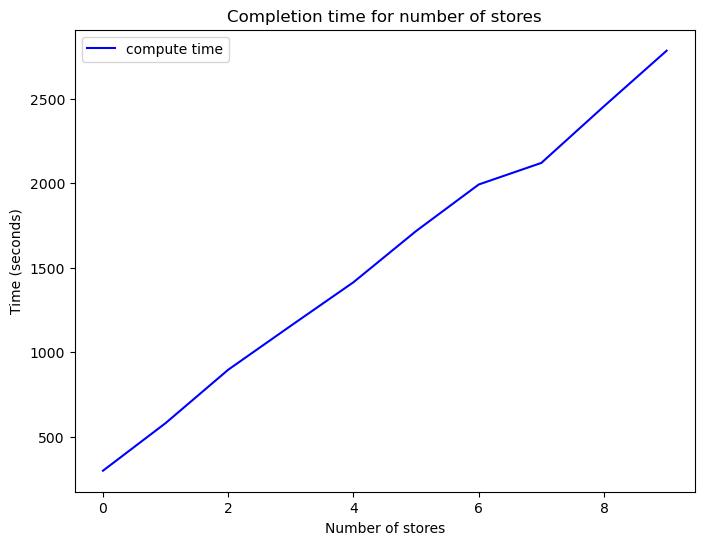

In [3]:
time_without_tuning = np.cumsum(pd.read_csv("HNN_Result_without_tuning.csv")["Time used"])

plt.figure(figsize=(8, 6))
plt.plot(range(0,10), time_without_tuning, label='compute time', color='blue')
plt.ylabel('Time (seconds)')
plt.xlabel('Number of stores')
plt.title('Completion time for number of stores')
plt.legend()
plt.show()

### 3.2 Algorithm without parameter tuning vs with parameter tuning

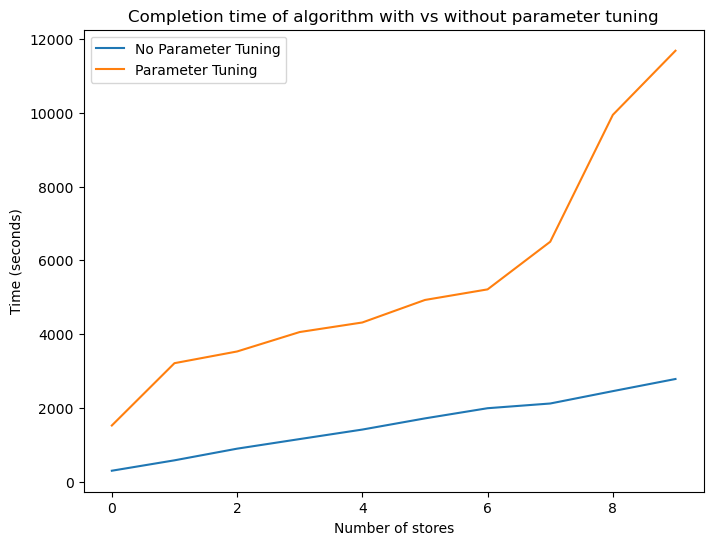

In [32]:
time_with_tuning = np.cumsum(pd.read_csv("HNN_Result_with_tuning.csv")["Time used"])

plt.figure(figsize=(8, 6))
plt.plot(time_without_tuning, label = "No Parameter Tuning")
plt.plot(time_with_tuning, label = "Parameter Tuning")
plt.ylabel('Time (seconds)')
plt.xlabel('Number of stores')
plt.title('Completion time of algorithm with vs without parameter tuning')
plt.legend()
plt.show()

In [62]:
KPI1_without_tuning = np.array(pd.read_csv("HNN_Result_without_tuning.csv")["Maximum KPI1"])
KPI1_with_tuning = np.array(pd.read_csv("HNN_Result_with_tuning.csv")["Maximum KPI1"])

KPI2_without_tuning = np.array(pd.read_csv("HNN_Result_without_tuning.csv")["Minimum KPI2"])
KPI2_with_tuning = np.array(pd.read_csv("HNN_Result_with_tuning.csv")["Minimum KPI2"])

SPC_without_tuning = np.array(pd.read_csv("HNN_Result_without_tuning.csv")["Space Used"])
SPC_with_tuning = np.array(pd.read_csv("HNN_Result_with_tuning.csv")["Space Used"])

MAXSPC_without_tuning = np.array(pd.read_csv("HNN_Result_without_tuning.csv")["Max Space"])
MAXSPC_with_tuning = np.array(pd.read_csv("HNN_Result_with_tuning.csv")["Max Space"])

SPC_Utility_without_tuning = SPC_without_tuning / MAXSPC_without_tuning
SPC_Utility_with_tuning = SPC_with_tuning / MAXSPC_with_tuning

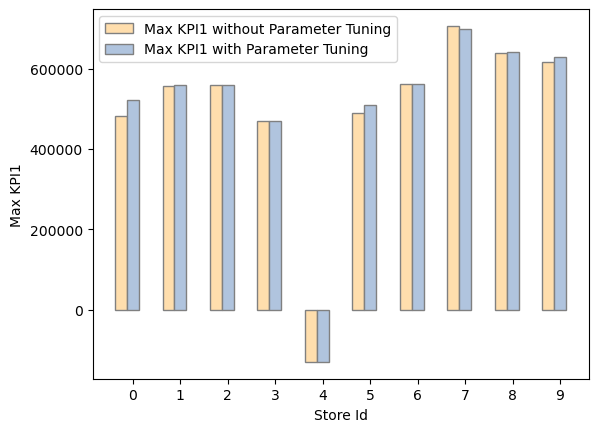

In [72]:
barWidth = 0.25
br1 = np.arange(len(KPI1_without_tuning))
br2 = [x + barWidth for x in br1]
plt.bar(br1, KPI1_without_tuning, width=barWidth,
        color ='navajowhite', edgecolor ='grey', label ='Max KPI1 without Parameter Tuning')
plt.bar(br2, KPI1_with_tuning, width=barWidth,
        color ='lightsteelblue', edgecolor ='grey', label ='Max KPI1 with Parameter Tuning')
plt.xlabel('Store Id')
plt.ylabel('Max KPI1')
plt.xticks([r + barWidth for r in range(len(KPI1_without_tuning))], ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.legend()
plt.show()

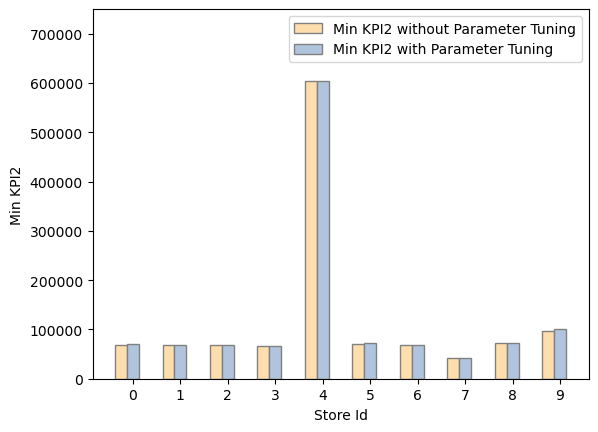

In [73]:
barWidth = 0.25
br1 = np.arange(len(KPI2_without_tuning))
br2 = [x + barWidth for x in br1]
plt.bar(br1, KPI2_without_tuning, width=barWidth,
        color ='navajowhite', edgecolor ='grey', label ='Min KPI2 without Parameter Tuning')
plt.bar(br2, KPI2_with_tuning, width=barWidth,
        color ='lightsteelblue', edgecolor ='grey', label ='Min KPI2 with Parameter Tuning')
plt.xlabel('Store Id')
plt.ylabel('Min KPI2')
plt.xticks([r + barWidth for r in range(len(KPI2_without_tuning))], ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.gca().set_ylim([0, 750000])
plt.legend()
plt.show()

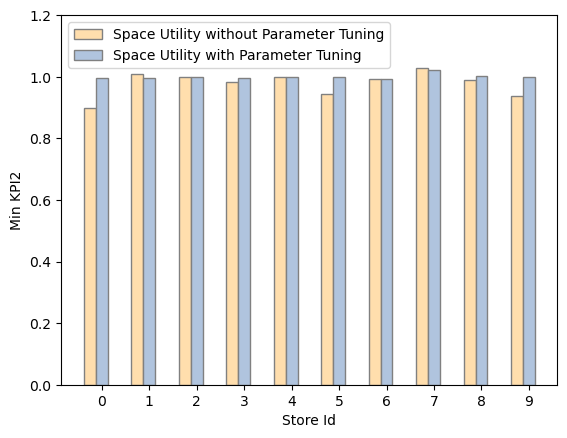

In [74]:
barWidth = 0.25
br1 = np.arange(len(SPC_Utility_without_tuning))
br2 = [x + barWidth for x in br1]
plt.bar(br1, SPC_Utility_without_tuning, width=barWidth,
        color ='navajowhite', edgecolor ='grey', label ='Space Utility without Parameter Tuning')
plt.bar(br2, SPC_Utility_with_tuning, width=barWidth,
        color ='lightsteelblue', edgecolor ='grey', label ='Space Utility with Parameter Tuning')
plt.xlabel('Store Id')
plt.ylabel('Space Utility')
plt.xticks([r + barWidth for r in range(len(SPC_Utility_without_tuning))], ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.gca().set_ylim([0, 1.2])
plt.legend()
plt.show()

### 3.3 Special Zone Computation

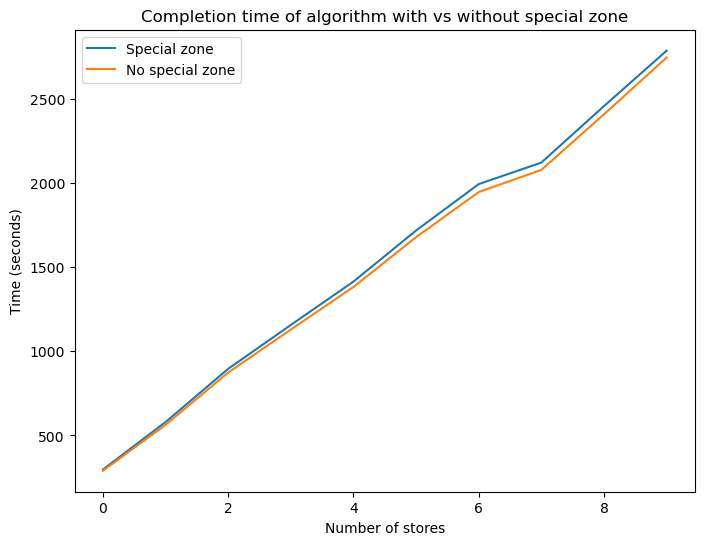

In [4]:
time_without_special = np.cumsum(pd.read_csv("HNN_Result_without_tuning_without_special.csv")["Time used"])

plt.figure(figsize=(8, 6))
plt.plot(time_without_tuning, label = "Special zone")
plt.plot(time_without_special, label = "No special zone")
plt.ylabel('Time (seconds)')
plt.xlabel('Number of stores')
plt.title('Completion time of algorithm with vs without special zone')
plt.legend()
plt.show()

### 3.4 Opt Priority Computation

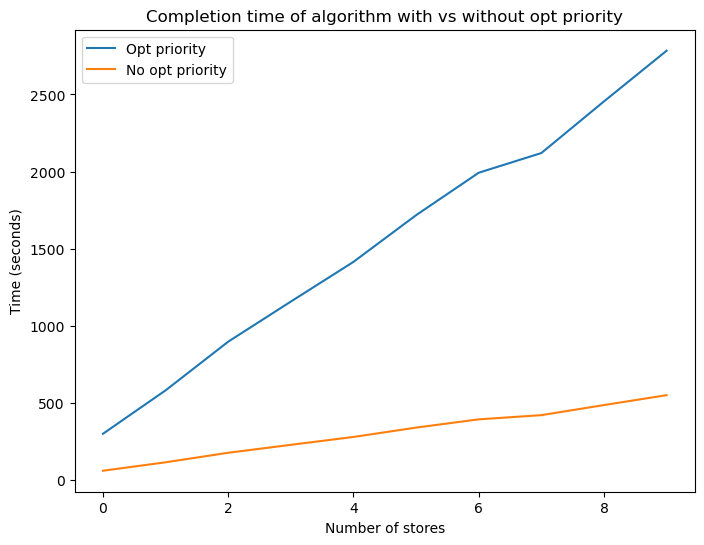

In [5]:
time_without_priority = np.cumsum(pd.read_csv("HNN_Result_without_tuning_without_priority.csv")["Time used"])

plt.figure(figsize=(8, 6))
plt.plot(time_without_tuning, label = "Opt priority")
plt.plot(time_without_priority, label = "No opt priority")
plt.ylabel('Time (seconds)')
plt.xlabel('Number of stores')
plt.title('Completion time of algorithm with vs without opt priority')
plt.legend()
plt.show()